# PRACTICAL MACHINE LEARNING

INSTRUCTIONS
============
 The goal of your project is to predict the manner in which they did the exercise. This is the "classe" variable in the training set. You may use any of the other variables to predict with. You should create a report describing how you built your model, how you used cross validation, what you think the expected out of sample error is, and why you made the choices you did. You will also use your prediction model to predict 20 different test cases.

INPUT DATA
==========

In [19]:
#read.csv(file_dest_training, na.strings=c("NA",""), header=TRUE)
#ExoData=read.csv(file="pml-training.csv",head=TRUE,sep=",", stringsAsFactors=FALSE)
ExoData=read.csv(file="pml-training.csv", na.strings=c("NA",""), header=TRUE)
nrow(ExoData)
#str(ExoData)
dim(ExoData)

[1] 19622

[1] 19622   160

FEATURES
========
Having verified that the schema of both the training and testing sets are not identical, I decided to eliminate both NA columns and other extraneous columns.


In [18]:
b=sapply(ExoData, function(x) sum(is.na(x)))
FullData=subset(ExoData,select=c(which(!b>0)), stringsAsFactors=FALSE)
#str(FullData)
dim(FullData)

[1] 19622    60

which leaves use with only 60 variables to train on.

In [17]:
smartData=FullData
smartData=smartData[,colSums(smartData != 0) != 0] 
dim(smartData)
s=sapply(smartData, function(x) sum(is.na(x)))
#str(smartData)

[1] 19622    60

### Random Forest Model
We implement a random forest model using cross validation to control overfitting: 

In [5]:
library(caret)
library(mlbench)
set.seed(3)

Loading required package: lattice
Loading required package: ggplot2


In [6]:
tData=smartData
tData$cvtd_timestamp=NULL #with these in, there was a factor level mismatch with final validation set
tData$new_window=NULL #  final validation set
dim(tData)
trainIdx=createDataPartition(tData$classe, p = .75, list=FALSE)
trainD=tData[trainIdx,]
testD=tData[-trainIdx,]
x <- trainD[,-58]
y <- trainD[,58]

[1] 19622    58

In [7]:
library(parallel)
library(doParallel)
cluster <- makeCluster(detectCores() - 1) # convention to leave 1 core for OS
registerDoParallel(cluster)

Loading required package: foreach
Loading required package: iterators


CROSS VALIDATION
================
we use 10-folds cross validation to control overfitting

In [8]:
fitControl <- trainControl(method = "cv",
                           number = 10,
                           allowParallel = TRUE)

Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



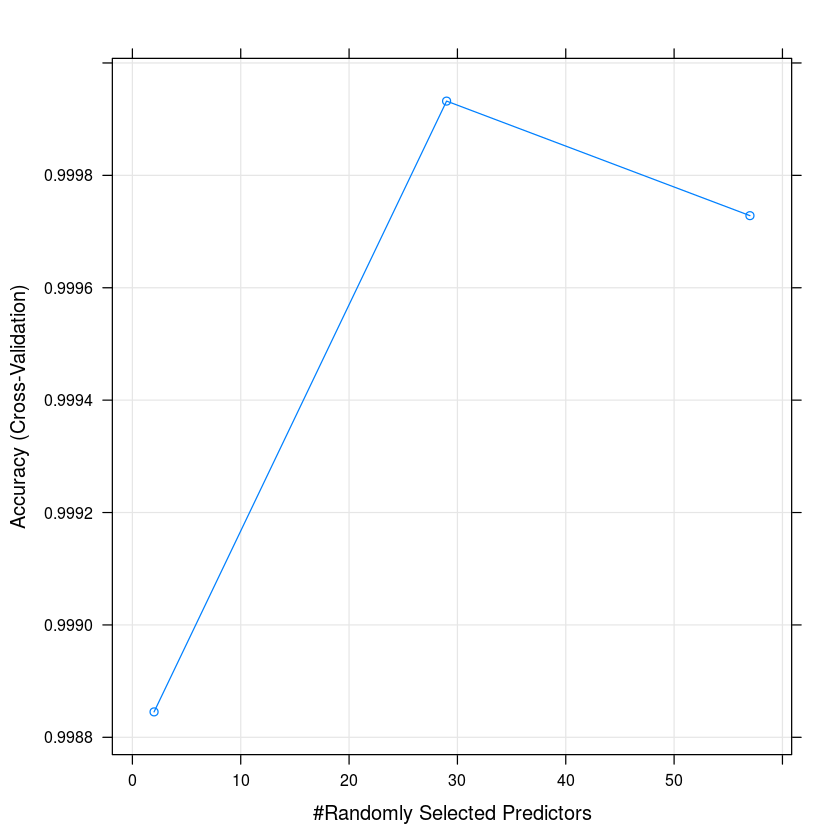

In [9]:
fit <- train(x,y, method="rf",data=trainD,trControl = fitControl)
plot(fit)

In [10]:
rf.pred=predict(fit,testD[,-58])
confusionMat=table(rf.pred,testD[,58])
confusionMat

       
rf.pred    A    B    C    D    E
      A 1395    0    0    0    0
      B    0  949    1    0    0
      C    0    0  854    0    0
      D    0    0    0  804    0
      E    0    0    0    0  901

In [14]:
#str(trainD)

the results appear to be too precise to be true, which means we are probably overfitting.
However, we are using cross validation to select the variables and it appears peak above 0.9998 accuracy around 30 variables. We where unable to find an explanation for overfitting and had to conclude that the high performance on the test set is probably due to data being artificial not having enough noise.

In [15]:
vData=read.csv(file="pml-testing.csv", na.strings=c("NA",""), header=TRUE)
b=sapply(vData, function(x) sum(is.na(x)))
fvData=subset(vData,select=c(which(!b>0)), stringsAsFactors=FALSE)
#str(vData)
#dim(vData)
svData=fvData
svData=svData[,colSums(svData != 0) != 0] 
dim(svData)
s=sapply(svData, function(x) sum(is.na(x)))
#str(svData)

[1] 20 60

In [16]:
validationData=svData
validationData$cvtd_timestamp=NULL
validationData$new_window=NULL
nrow(validationData)
#str(validationData)
dim(validationData)
validation.pred=predict(fit, validationData)
validation.pred

[1] 20

[1] 20 58

[1] A A A A A A A A A A A A A A A A A A A A
Levels: A B C D E